<a href="https://colab.research.google.com/github/El-Do-RaDo/Housing_price_prediction/blob/master/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [45]:
#uploading files 

uploaded = files.upload()

Saving housing.csv to housing (1).csv


In [46]:

import pandas as pd

#reading the datasets
housing = pd.read_csv("housing.csv")

import numpy as np

#splitting the data set for training and testing
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set) , len(test_set))

16512 4128


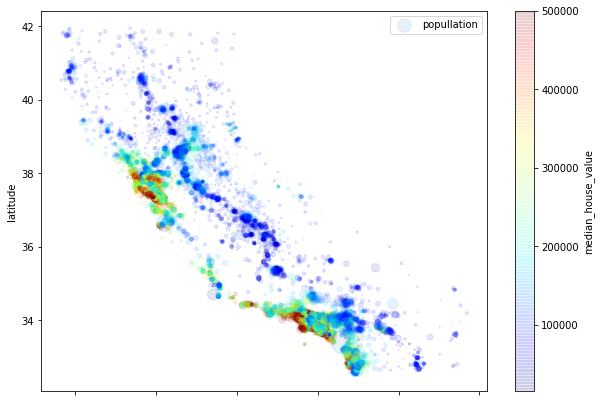

In [47]:
import matplotlib.pyplot as plt

#visualizing the data 
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, s=housing['population']/100, label="popullation", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [48]:

#looking for the corelation
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f580a36d5c0>,
      dtype=object)

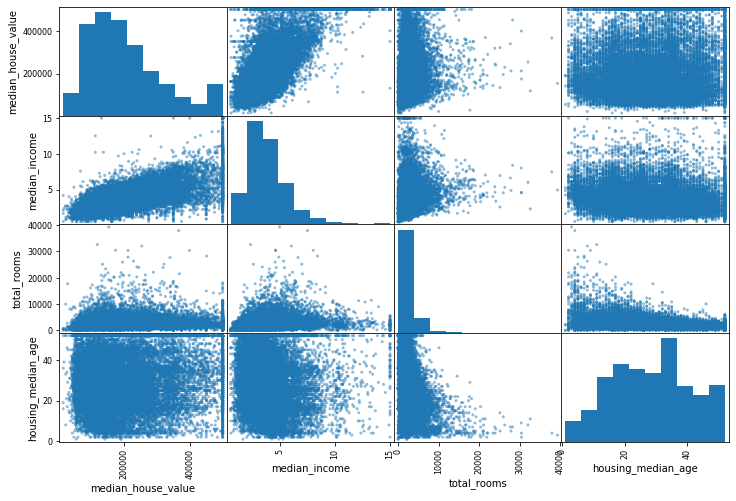

In [49]:
#finding the data quirks with finding corelation
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))

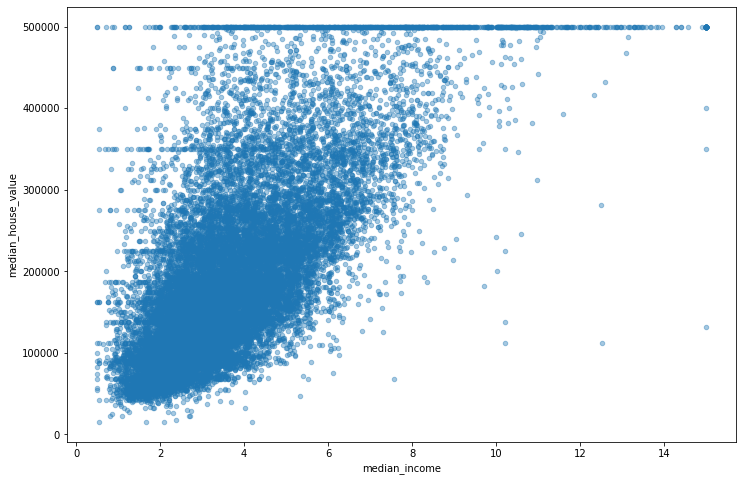

In [50]:
housing.plot(kind="scatter" ,x="median_income", y="median_house_value", alpha=0.4, figsize=(12,8))

In [51]:
#exprimenting with attribute combination

housing["rooms_per_household"] = housing['total_rooms']/housing['households']
housing["bedrooms_per_room"] = housing['total_bedrooms']/housing['total_rooms']
housing["population_per_household"] = housing['population']/housing['households']

corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

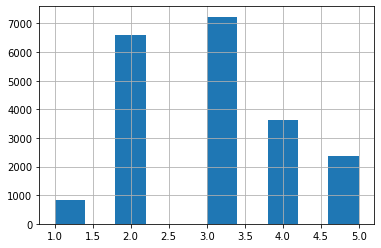

In [52]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 
                               4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [0]:
#preparing the data for machine learning algorithms

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [0]:
!pip install --user --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


In [55]:
# data cleaning

housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

imputer.statistics_



array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        5.23228423e+00,  2.03031374e-01,  2.81765270e+00,  3.00000000e+00])

In [0]:
housing_num.median().values

x = imputer.transform(housing_num)

housing_tr = pd.DataFrame(x, columns=housing_num.columns)

In [57]:
#handling text and categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [58]:
from sklearn.preprocessing import OneHotEncoder
encoders = OneHotEncoder()

housing_cat_1hot = encoders.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [59]:
from sklearn.preprocessing import LabelBinarizer

encoder1 = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder1.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [0]:
#custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, x, y=None):
        return self
    def transform(self, x, y=None):
        rooms_per_household = x[:, rooms_ix]/x[:, household_ix]
        population_per_household = x[:, population_ix]/x[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = x[:, bedrooms_ix]/x[:, rooms_ix]
            return np.c_[x, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[x, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [0]:
#transformation pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)


In [0]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)), ('imputer', SimpleImputer(strategy="median")), ('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])

cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), ('label_binarizer', MyLabelBinarizer())])

In [64]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline)])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [65]:
housing_prepared.shape

(16512, 20)

In [66]:
#training and evaluating on the training set

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("predictions : ", lin_reg.predict(some_data_prepared))

predictions :  [200860.48973484 325527.93559759 201882.47991703  54956.04539331
 188116.26928254]


In [67]:
print("lables : ", list(some_labels))

lables :  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [68]:
#measuring regression mobels RMSE on whole training set

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67784.32202861732

In [69]:
#trying different model for the dataset for more accurate results

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [71]:
#better evaluation using cross-validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("scores : ", scores)
    print("mean : ", scores.mean())
    print("standard deviation : ", scores.std())

display_scores(tree_rmse_scores)

scores :  [70526.1595829  67843.57111451 70255.99663653 67934.8085422
 69642.2849538  73797.2508876  69588.68826195 70755.18847824
 74653.40698834 69776.85785582]
mean :  70477.42133018697
standard deviation :  2096.874306479728


In [72]:
#computing the same score for liner Regrassion model

lin_scores  = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores :  [66139.89793892 66402.64250448 67318.10039379 73980.14151657
 67666.27878335 70758.72248018 63820.26082748 67348.34338089
 70423.45351656 67291.28882149]
mean :  68114.91301637127
standard deviation :  2722.108635196741


In [73]:
#trying out different model for better performance

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [74]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18721.272906835253

In [75]:
forest_scores  = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores :  [49637.93592429 47148.4718471  49878.64586757 52433.25787756
 49706.27785169 53052.01020947 49111.3352866  47801.39012017
 52964.07469986 49848.19856953]
mean :  50158.15982538482
standard deviation :  1943.7350775879954


In [76]:
#fine tuning of model
#using grid search cv from sklearn

from sklearn.model_selection import  GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features' : [2,3,4]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [77]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [78]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [79]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65317.35441274882 {'max_features': 2, 'n_estimators': 3}
57401.851383071924 {'max_features': 2, 'n_estimators': 10}
54482.690481285645 {'max_features': 2, 'n_estimators': 30}
61540.630945055294 {'max_features': 4, 'n_estimators': 3}
54850.134049773216 {'max_features': 4, 'n_estimators': 10}
52520.0146607842 {'max_features': 4, 'n_estimators': 30}
60829.97211745596 {'max_features': 6, 'n_estimators': 3}
54490.43578503189 {'max_features': 6, 'n_estimators': 10}
51924.40119201509 {'max_features': 6, 'n_estimators': 30}
60501.60115876529 {'max_features': 8, 'n_estimators': 3}
54190.81683697581 {'max_features': 8, 'n_estimators': 10}
51826.59749878635 {'max_features': 8, 'n_estimators': 30}
64728.65781989993 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56380.04137302581 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
62103.479493629064 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54727.606216963555 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [80]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.34130344e-02, 4.88632187e-02, 4.16619948e-02, 1.42260019e-02,
       1.47609370e-02, 1.41006357e-02, 1.42248681e-02, 2.34159757e-01,
       2.22081849e-02, 2.74469424e-02, 6.36919200e-02, 1.93084444e-01,
       1.87605889e-02, 6.40708132e-02, 2.45059614e-02, 4.49727790e-03,
       1.40889096e-01, 6.31399972e-05, 1.81965893e-03, 3.55152461e-03])

In [81]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2341597566914635, 'median_income'),
 (0.19308444441394831, 'income_cat'),
 (0.14088909609292435, 'INLAND'),
 (0.06407081315012028, 'pop_per_hhold'),
 (0.06369191995589472, 'population_per_household'),
 (0.053413034426190026, 'longitude'),
 (0.048863218700842835, 'latitude'),
 (0.041661994837992475, 'housing_median_age'),
 (0.027446942417922754, 'bedrooms_per_room'),
 (0.024505961426225364, 'bedrooms_per_room'),
 (0.022208184893824694, 'rooms_per_household'),
 (0.01876058891286164, 'rooms_per_hhold'),
 (0.014760937004174272, 'total_bedrooms'),
 (0.014226001907977594, 'total_rooms'),
 (0.014224868065559318, 'households'),
 (0.014100635665498795, 'population'),
 (0.0044972778972215, '<1H OCEAN'),
 (0.0035515246148989867, 'NEAR OCEAN'),
 (0.0018196589272836449, 'NEAR BAY'),
 (6.313999717473458e-05, 'ISLAND')]

In [84]:
#evaluating the system on the test set 

final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49311.687710316655